In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
import optuna
import warnings
warnings.filterwarnings("ignore")
import shap
from EngineerFeature import FeatureEngineer

In [5]:
# Normalized, one-hot-encoded, and feature-engineered dataset
data = pd.read_csv('../final_data.csv')

In [6]:
# Splitting features and target variable
X = data.drop("popularity", axis=1)   # features
y = data["popularity"]               # target

In [7]:
print(X.columns)

Index(['artist', 'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_count', 'subgenre_album rock',
       'subgenre_big room', 'subgenre_classic rock', 'subgenre_dance pop',
       'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'album_age_log', 'playlist_count_final'],
      dtype='object')


In [8]:
# Split the dataset into training(%80) and test(%20) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
fe = FeatureEngineer()
X_train = fe.fit_transform(X_train, y_train)
X_test = fe.transform(X_test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = X_train.columns#.difference(['artist_avg_popularity'])#, 'artist_song_count'])
X_train = pd.DataFrame(
    scaler.fit_transform(X_train[cols]),
    columns=cols,#X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test[cols]),
    columns=cols,#X_test.columns,
    index=X_test.index
)
print(X_train.shape, X_test.shape)

(22684, 41) (5672, 41)


In [9]:
# y_train_pred_mean = [y_train.mean()] * len(y_train)
# y_test_pred_mean  = [y_train.mean()] * len(y_test)

# print("BASELINE (train): MAE, RMSE, R2 =",
#       mean_absolute_error(y_train, y_train_pred_mean),
#       np.sqrt(mean_squared_error(y_train, y_train_pred_mean)),
#       r2_score(y_train, y_train_pred_mean))

# print("BASELINE (test): MAE, RMSE, R2 =",
#       mean_absolute_error(y_test, y_test_pred_mean),
#       np.sqrt(mean_squared_error(y_test, y_test_pred_mean)),
#       r2_score(y_test, y_test_pred_mean))


In [10]:
# Base Random Forest model evaluation with cross-validation
rf_base = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(
    rf_base,
    X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

print("Base RF CV MAE:", -scores.mean())
print("STD:", scores.std())

Base RF CV MAE: 10.001451917809957
STD: 0.08514861382071007


In [11]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, 0.7]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)

    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score   # MAE minimize edildiği için


In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, show_progress_bar=True)


[I 2025-12-12 18:27:09,232] A new study created in memory with name: no-name-9729a360-ac5d-4301-8755-7dd6d2ba7acb


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-12-12 18:27:23,451] Trial 0 finished with value: 10.457953185022681 and parameters: {'n_estimators': 695, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 10.457953185022681.
[I 2025-12-12 18:28:06,670] Trial 1 finished with value: 9.690477535846801 and parameters: {'n_estimators': 797, 'max_depth': 23, 'min_samples_split': 34, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 1 with value: 9.690477535846801.
[I 2025-12-12 18:28:21,164] Trial 2 finished with value: 10.475737981937002 and parameters: {'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 30, 'min_samples_leaf': 9, 'max_features': 0.3}. Best is trial 1 with value: 9.690477535846801.
[I 2025-12-12 18:28:28,103] Trial 3 finished with value: 11.773335287011545 and parameters: {'n_estimators': 449, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 9.690477535846801.
[I 20

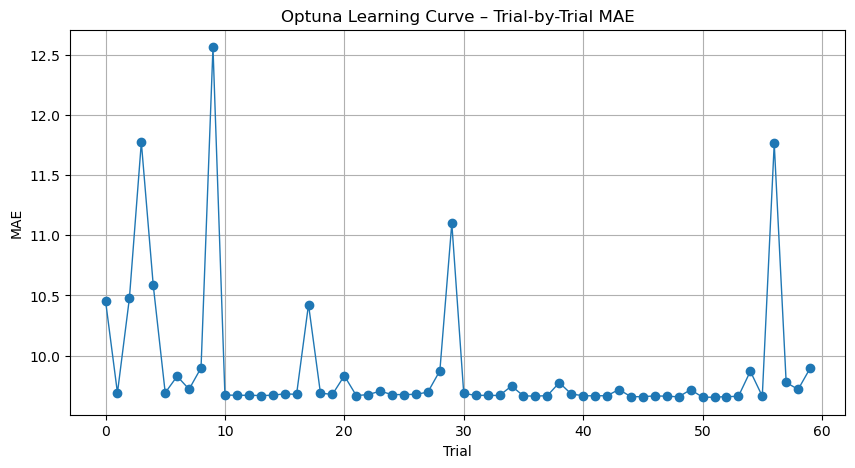

In [13]:
# Tüm trial skorlarını çekelim
trial_numbers = []
trial_mae = []

for t in study.trials:
    if t.value is not None:   # başarısız trial'ları at
        trial_numbers.append(t.number)
        trial_mae.append(t.value)

plt.figure(figsize=(10, 5))
plt.plot(trial_numbers, trial_mae, marker="o", linewidth=1)
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.title("Optuna Learning Curve – Trial-by-Trial MAE")
plt.grid(True)
plt.show()


In [14]:
best_params = study.best_params
best_params

{'n_estimators': 607,
 'max_depth': 11,
 'min_samples_split': 19,
 'min_samples_leaf': 7,
 'max_features': 0.7}

In [15]:
best_rf = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

Test MAE: 15.395353897645897
Test RMSE: 20.451003995957088
Test R2: 0.2583586899508018


In [16]:
explainer = shap.TreeExplainer(best_rf)

# Test setini açıklayacağız
shap_values = explainer.shap_values(X_test)

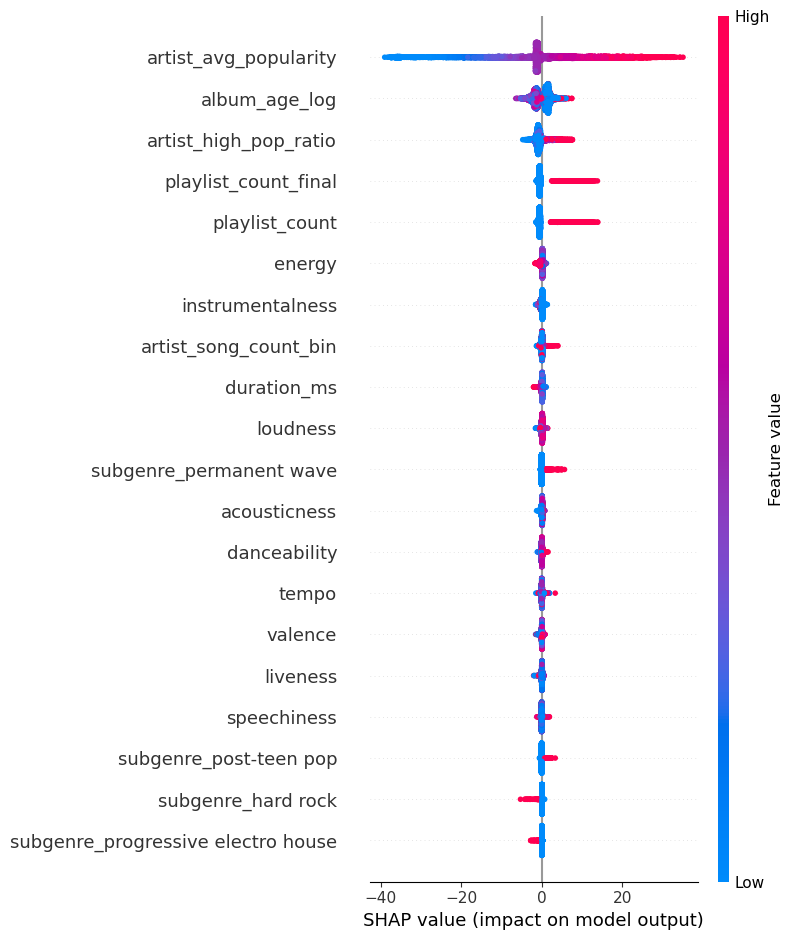

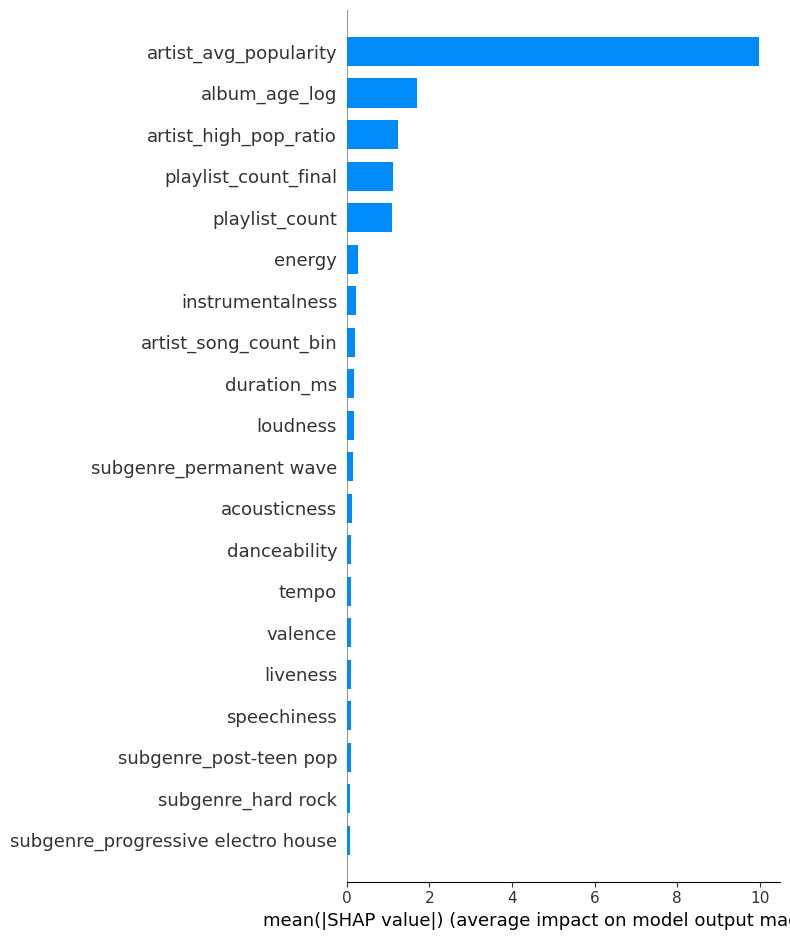

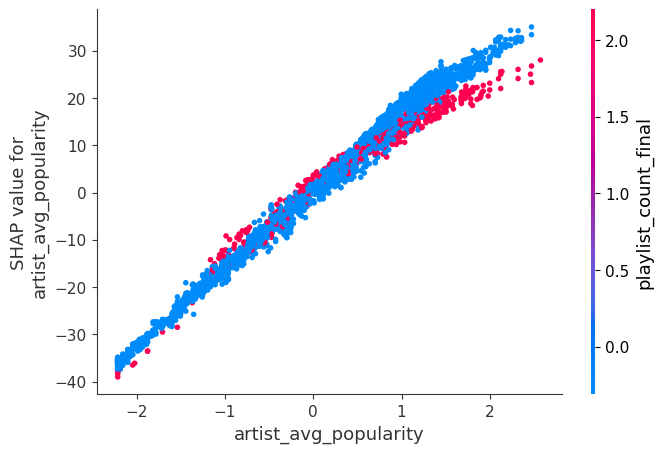

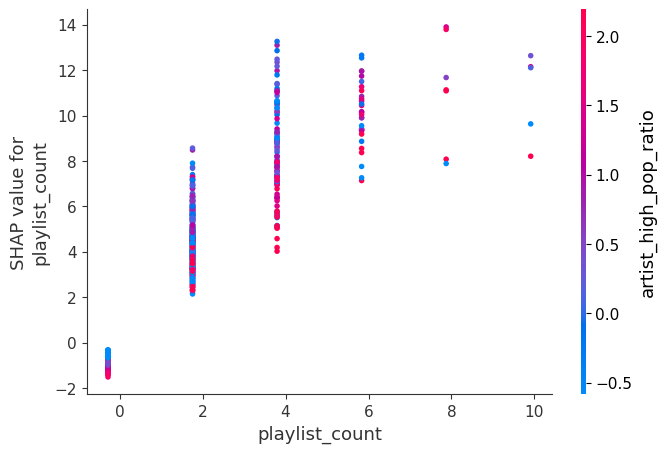

In [17]:
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.dependence_plot("artist_avg_popularity", shap_values, X_test)

shap.dependence_plot("playlist_count", shap_values, X_test)


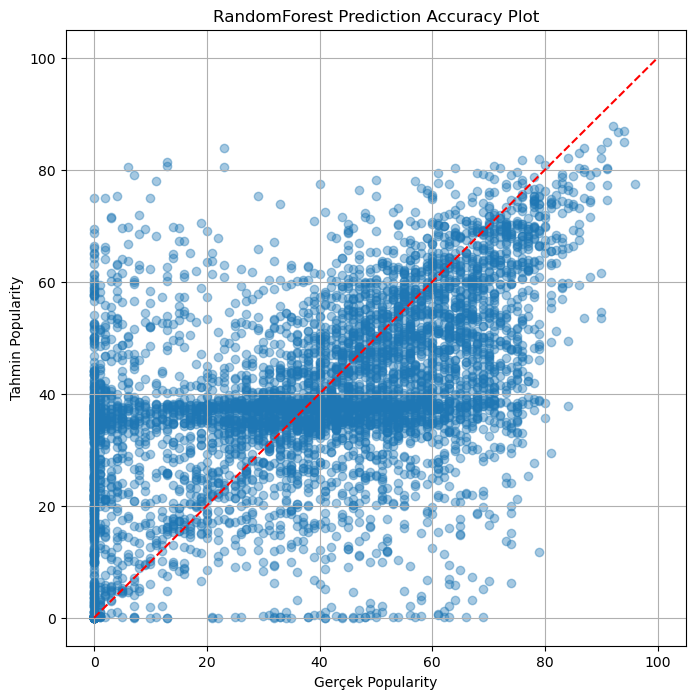

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel("Gerçek Popularity")
plt.ylabel("Tahmin Popularity")
plt.title("RandomForest Prediction Accuracy Plot")
plt.grid(True)
plt.show()

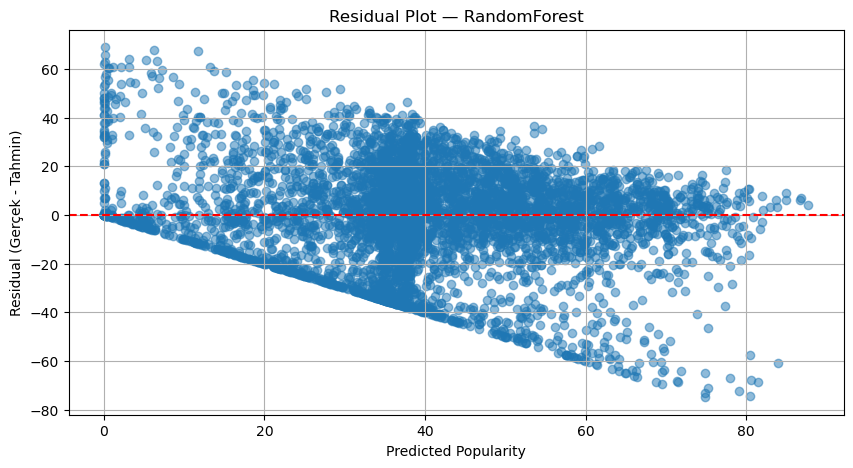

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Popularity")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Residual Plot — RandomForest")
plt.grid(True)
plt.show()


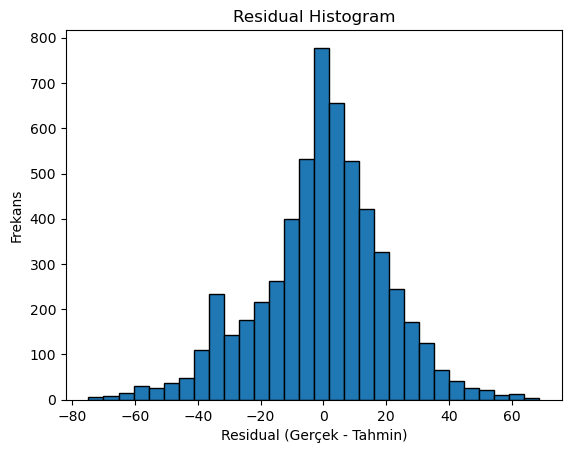

In [20]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Histogram")
plt.xlabel("Residual (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.show()



>>> Plotting 1D Partial Dependence for: ['playlist_count', 'energy', 'duration_ms']


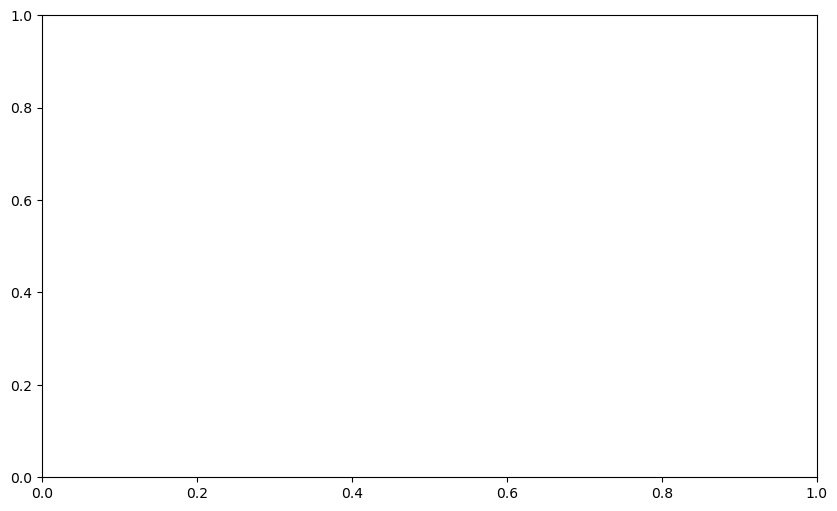

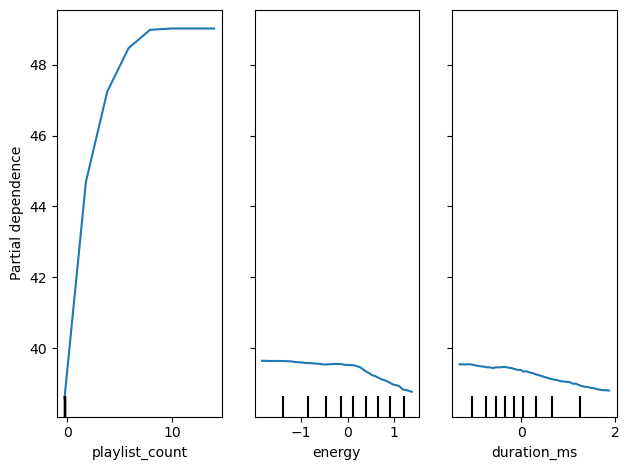

In [21]:

features = ["artist_avg_popularity", "playlist_count", "energy", "duration_ms"]

features_for_pdp = []

for f in ["artist_avg_popularity", "playlist_count", "energy", "duration_ms"]:
    if f in X.columns:
        features_for_pdp.append(f)

if features_for_pdp:
    print("\n>>> Plotting 1D Partial Dependence for:", features_for_pdp)
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_train,
        features_for_pdp,
        kind="average",
        grid_resolution=50
    )
    plt.tight_layout()
    plt.show()


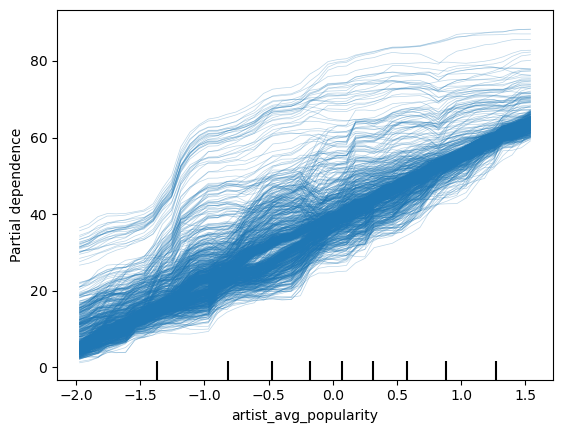

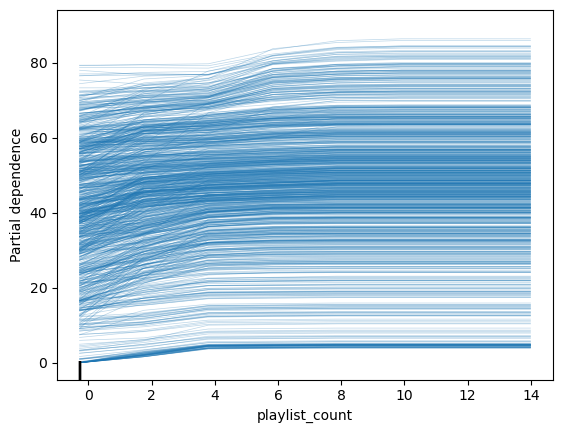

In [22]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    best_rf, X_train, ["artist_avg_popularity"], kind="individual", grid_resolution=50
)
plt.show()

PartialDependenceDisplay.from_estimator(
    best_rf, X_train, ["playlist_count"], kind="individual", grid_resolution=50
)
plt.show()


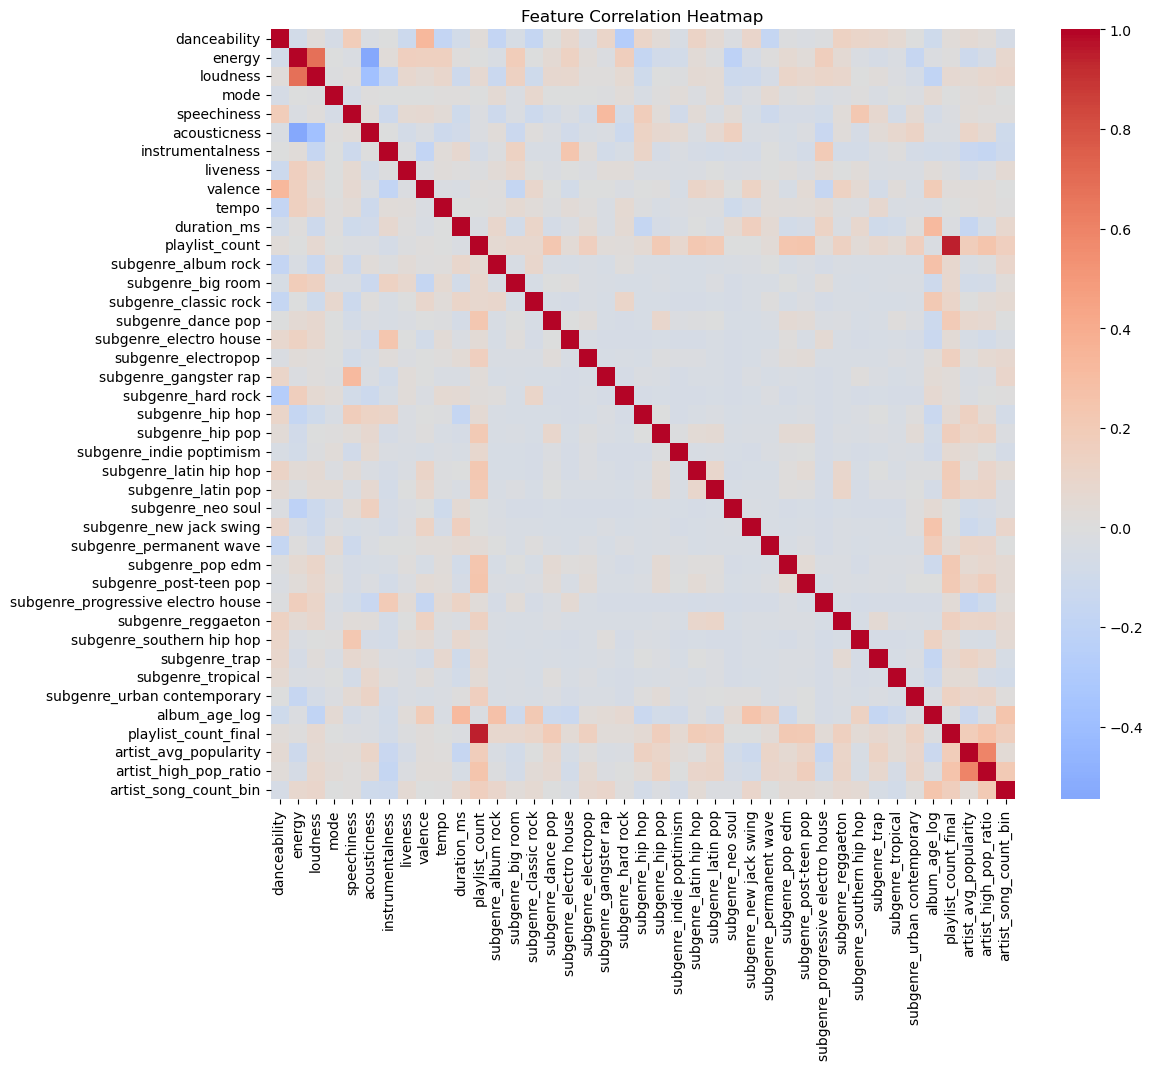

In [23]:
import seaborn as sns
corr = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [24]:
# interaction_values = shap.TreeExplainer(best_rf).shap_interaction_values(X_test)

# shap.summary_plot(interaction_values, X_test)


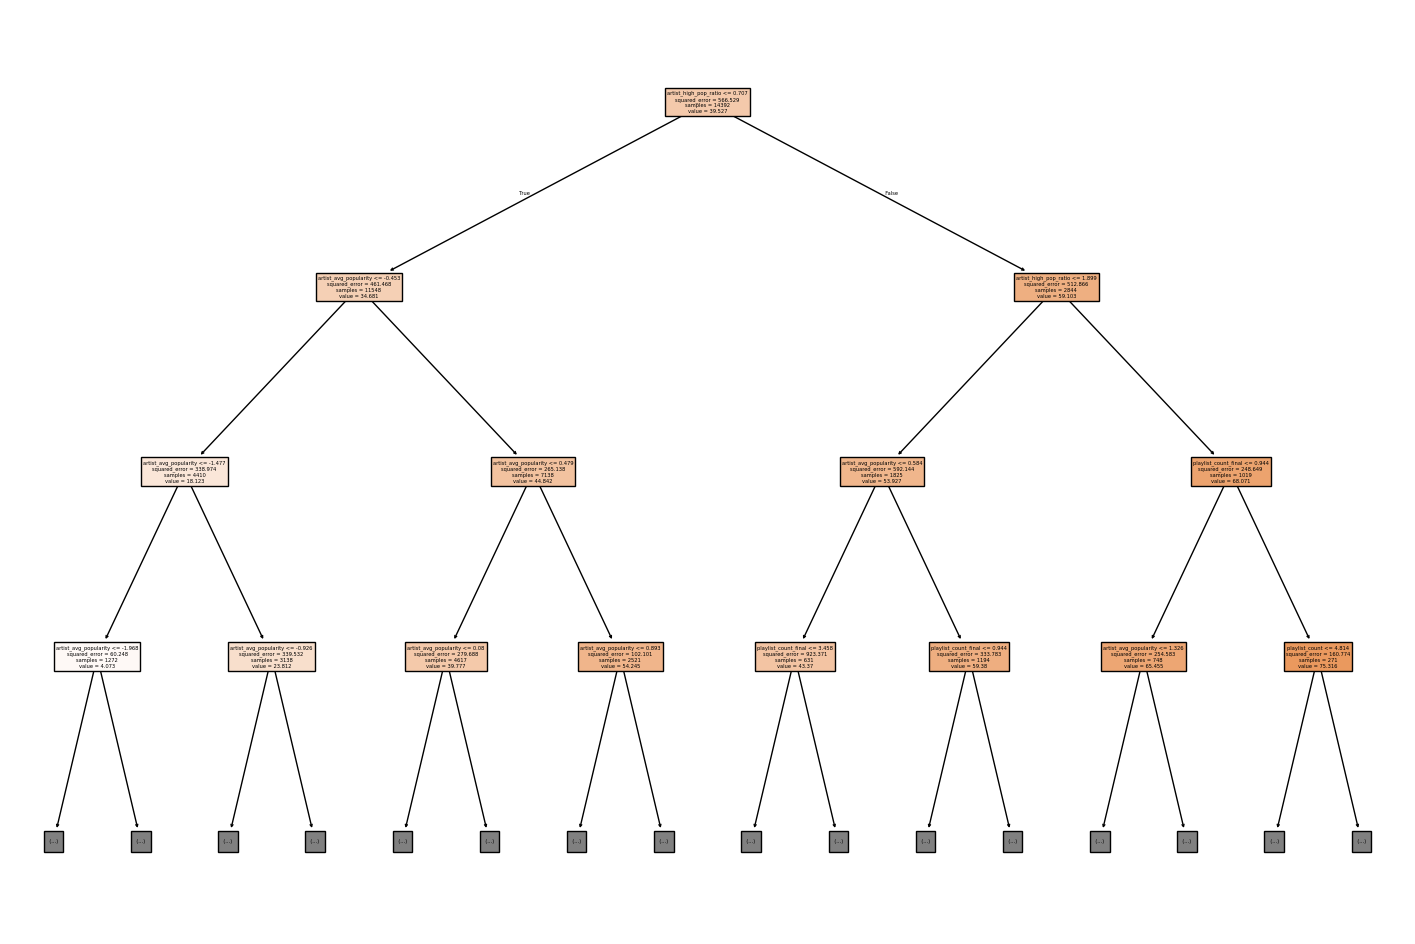

In [25]:
estimator = best_rf.estimators_[0]

from sklearn.tree import plot_tree
plt.figure(figsize=(18, 12))
plot_tree(estimator, feature_names=X_train.columns, filled=True, max_depth=3)
plt.show()


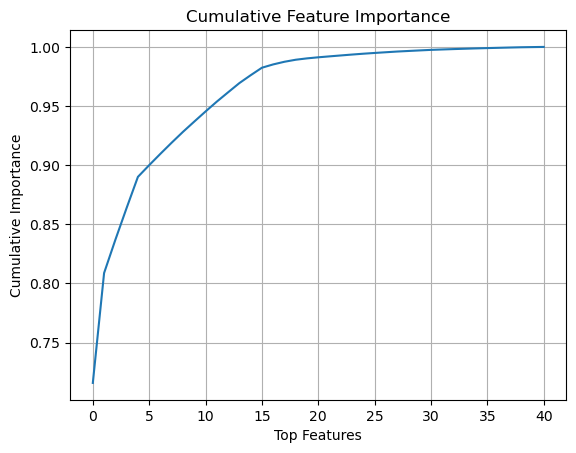

In [26]:
imp = best_rf.feature_importances_
sorted_imp = np.sort(imp)[::-1]
cumulative = np.cumsum(sorted_imp)

plt.plot(cumulative)
plt.xlabel("Top Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance")
plt.grid(True)
plt.show()


Top 20 features by importance:
                               feature  importance
38               artist_avg_popularity    0.715898
39               artist_high_pop_ratio    0.092940
11                      playlist_count    0.028090
36                       album_age_log    0.026967
37                playlist_count_final    0.026235
2                             loudness    0.009894
9                                tempo    0.009646
10                         duration_ms    0.009413
1                               energy    0.009135
7                             liveness    0.008656
4                          speechiness    0.008550
8                              valence    0.008335
0                         danceability    0.007866
5                         acousticness    0.007791
40               artist_song_count_bin    0.006642
6                     instrumentalness    0.006354
27             subgenre_permanent wave    0.002799
29              subgenre_post-teen pop    0.002242

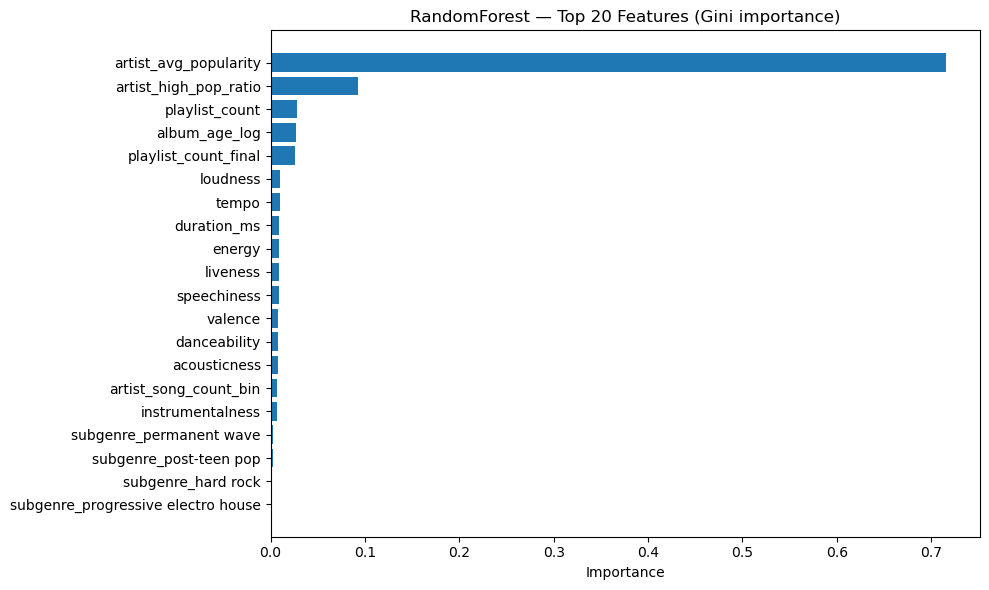

In [27]:
# Feature Importances
importances = best_rf.feature_importances_

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
})
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("\nTop 20 features by importance:")
print(feature_importance.head(20))

# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"].head(20),
         feature_importance["importance"].head(20))
plt.gca().invert_yaxis()
plt.title("RandomForest — Top 20 Features (Gini importance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()